# Dijkstra path finding algorithm

Created by - Sanjana Tule

Date - 26/08/2021

*   Run Dijkstra for path finding on graph.
*  Custom weight function - options are length/combined_risk or cobination of length + combined_risk




In [1]:
# !pip install osmnx
# !apt install python3-rtree

In [2]:
# import libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import requests
import osmnx as ox
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import math
import time
import warnings
warnings.filterwarnings("ignore")

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PART 2 - PATH FINDING USING ABSTRACT AND DETAILED GRAPH

In [24]:
# Load abstract and detailed graph
graph_detailed = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/2_all_graph_all_risk_added.pickle')
graph_abstract = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/3_abstract_graph.pickle')

nodes_nr_all = ox.graph_to_gdfs(graph_detailed,edges=False)
abstract_intra_nodes = ox.graph_to_gdfs(graph_abstract,edges=False)

nodes,edges = ox.graph_to_gdfs(graph_detailed)
edges['combined_risk_length'] = edges['combined_risk'] + edges['length']

display(edges.head())
graph_detailed = ox.graph_from_gdfs(nodes,edges)

osmid  ... combined_risk_length
u          v          key                          ...                     
21569692   4682380491 0    [185913115, 401489878]  ...           383.855747
           6784129512 0                 401489883  ...            11.614000
           6784129514 0                 401489877  ...            17.276000
4682380491 21569692   0    [185913115, 401489878]  ...           383.855747
           4682381110 0                 474236841  ...            42.973208

[5 rows x 21 columns]

In [25]:
 ##################################### PART 2 - FIND THE ROUTE #################################################################
 ###############################################################################################################################

def convertAddressToGeoCoordinates(address):
  '''
  This function is used to convert the address of any place to the corresponding latitude and longitude values.

  Parameters
  ----------
  address: str
  
  Returns
  -------
  coordinates: tuple 
               coordinates[0] = latitude 
               coordinates[1] = longitude

  '''
  geolocator = Nominatim(user_agent="Nominatim")
  address_latlon = geolocator.geocode(address)
  coordinates = (address_latlon.latitude, address_latlon.longitude)
  return coordinates



# euclidean distance
def get_euclidean_distance(s,geom):
    return ox.distance.euclidean_dist_vec(s[1],s[0],geom.bounds[1],geom.bounds[0])

# euclidean distance reverse
def get_euclidean_distance_r(s,geom):
    return ox.distance.euclidean_dist_vec(s[0],s[1],geom.bounds[1],geom.bounds[0])

# nearest park
def find_nearest_park_shelter(graph_detailed_nodes,source_coordinates,type):
  nodes_park = graph_detailed_nodes[graph_detailed_nodes['evacuation_type']== type]
  euc_distance_parks = nodes_park.geometry.apply(lambda x: get_euclidean_distance_r(source_coordinates,x))
  return euc_distance_parks.sort_values().index.values[0]

# def my_weigh_func(u, v, d):
#     edge_len = d.get("length", 1)
#     edge_risk = d.get("risk",1)
#     return edge_len + edge_risk

# find shortest route
def find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,graph_abstract_nodes,graph_detailed_nodes,weight_to_use):
  
  # record time
  start_time = time.time()

  # find nearest node to the address in the detailed graph
  source_node, source_dist = ox.get_nearest_node(graph_detailed,source_coordinates,return_dist=True)
  #print('source node in detailed graph',source_node)

  # find the destination if not given
  if choice_of_destination == 1: # park
    dest_node = find_nearest_park_shelter(graph_detailed_nodes,source_coordinates,'park')
    #print('Destination node in detailed graph',dest_node)
  elif choice_of_destination == 2: # shelter
    dest_node = find_nearest_park_shelter(graph_detailed_nodes,source_coordinates,'shelter')
    #print('Destination node in detailed graph',dest_node)
  else:
    # find nearest node to the address in the detailed graph
    dest_node, dest_dist = ox.get_nearest_node(graph_detailed,destination_coordinates,return_dist=True)
    #print('Destination node in detailed graph',dest_node)
  
  # find the shortest path betwen destination node in detailed graph to the destination node in the abstract graph
  complete_path = nx.shortest_path(G =graph_detailed,source=source_node, target=dest_node, weight=weight_to_use, method='dijkstra')
  #print("ROUTE",complete_path)

  A_time = (time.time() - start_time)
  print("TOTAL TIME",A_time)

  # Plot route
  fig, ax = ox.plot_graph_route(graph_detailed, complete_path, route_linewidth=6, node_size=0, bgcolor='k',figsize=(20,20))

  # length and risk
  total_length = sum(nx.Graph(graph_detailed)[u][v].get('length') for u, v in zip(complete_path[:-1], complete_path[1:]))
  total_risk = sum(nx.Graph(graph_detailed)[u][v].get('combined_risk') for u, v in zip(complete_path[:-1], complete_path[1:]))

  # total length and risk
  print("LENGTH OF THE ROUTE",total_length)
  print("RISK OF THE ROUTE",total_risk)

DEMO 1 - 
FIND PATH FOR CUSTOM DESTINATION

TOTAL TIME 0.5324082374572754


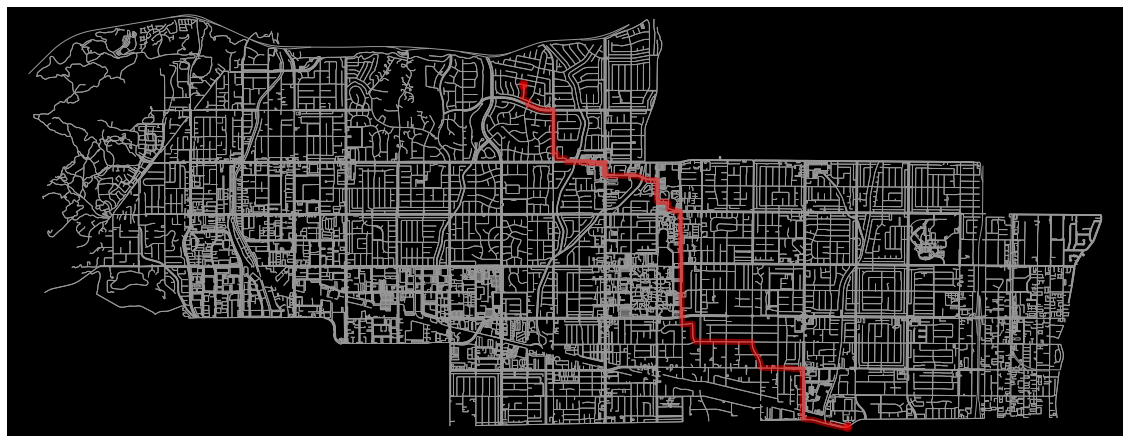

LENGTH OF THE ROUTE 10078.114000000001
RISK OF THE ROUTE 230.78518255937615


In [26]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

# source_address = input('Enter your Current Address.')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 3
source_address = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_address = "7741 Hayvenhurst Ave, Van Nuys, CA 91406"
destination_coordinates = convertAddressToGeoCoordinates(destination_address)
  
# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all,weight_to_use='combined_risk_length')

# Demo purposes - option 3
# Source Address = 19130 Tulsa St, Northridge, CA 91326
# Destination Address = '7741 Hayvenhurst Ave, Van Nuys, CA 91406'

TOTAL TIME 0.3334381580352783


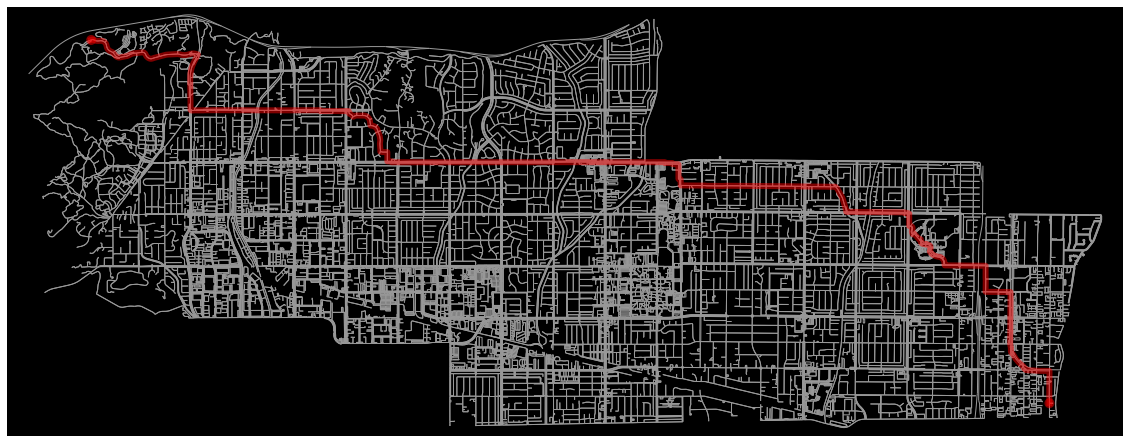

LENGTH OF THE ROUTE 20322.265000000003
RISK OF THE ROUTE 451.1949485997874


In [27]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 3
source_address = "22801 Santa Susana Pass Rd, Chatsworth, CA 91311"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_address = "8418 Noble Ave, North Hills, CA 91326"
destination_coordinates = convertAddressToGeoCoordinates(destination_address)


# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all,weight_to_use='combined_risk_length')


# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311
# Destination Address = 8418 Noble Ave, North Hills, CA 91326

TOTAL TIME 0.34518885612487793


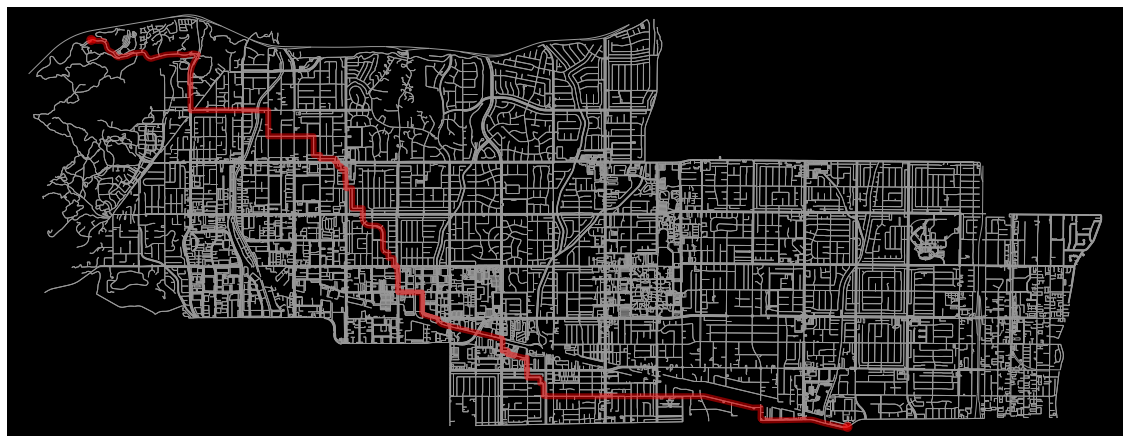

LENGTH OF THE ROUTE 17236.662000000004
RISK OF THE ROUTE 454.2940978376458


In [28]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 3
source_address = "22801 Santa Susana Pass Rd, Chatsworth, CA 91311"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_address = "7741 Hayvenhurst Ave, Van Nuys, CA 91406"
destination_coordinates = convertAddressToGeoCoordinates(destination_address)
  
# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all,weight_to_use='combined_risk_length')

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311
# Destination Address = 7741 Hayvenhurst Ave, Van Nuys, CA 91406

DEMO 2 - 
FIND PATH FOR NEAREST PARK


TOTAL TIME 0.09187912940979004


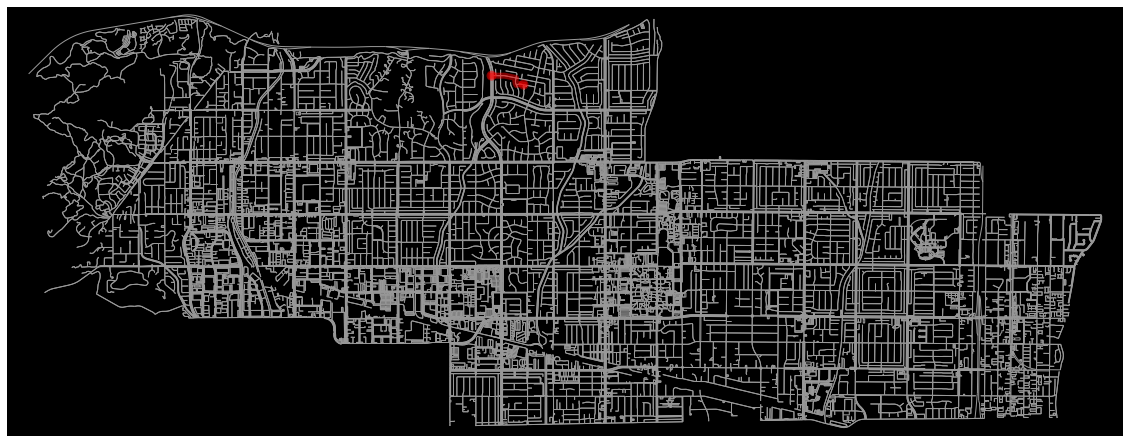

LENGTH OF THE ROUTE 610.6160000000001
RISK OF THE ROUTE 12.062389223679546


In [29]:
###### MAIN FUNCTION - NEAREST PARK #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 1
source_address = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_coordinates = ''

# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all,weight_to_use='combined_risk_length')


DEMO 3 - 
FIND PATH FOR NEAREST SHELTER

TOTAL TIME 0.40796709060668945


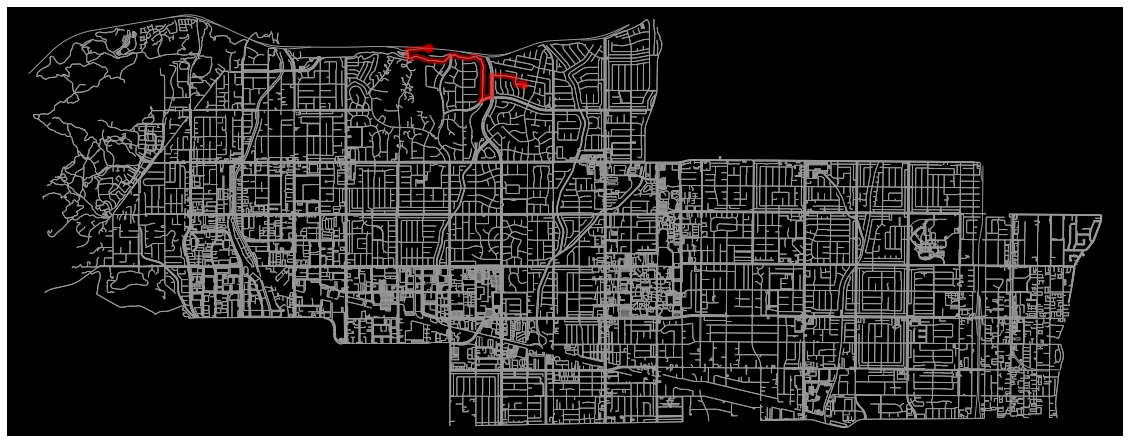

LENGTH OF THE ROUTE 3470.8469999999998
RISK OF THE ROUTE 36.411768876285


In [30]:
###### MAIN FUNCTION - NEAREST SHELTER #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 2
source_address = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_coordinates = ''
  
# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all,weight_to_use='combined_risk_length')